In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
plt.style.use('seaborn-whitegrid')

In [66]:
RANDOM_STATE = 42

danger_levels = [
    (11.7, 10.5),
    (1, 0),
    (11.7, 10.5)
]

In [3]:
data = pd.read_csv('../data.txt', sep='\t')

In [6]:
data['X3'].plot()

KeyError: 'X3'

In [124]:
data.to_excel('test.xlsx', engine='openpyxl', index=False)

In [47]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import pacf

In [38]:
def ewma(x, alpha=None):
    if alpha is None:
        alpha = 2 / (len(x) + 1)
    x = np.array(x)
    n = x.size

    w0 = np.ones(shape=(n, n)) * (1 - alpha)
    p = np.vstack([np.arange(i, i-n, -1) for i in range(n)])

    w = np.tril(w0**p,0)

    return np.dot(w, x[::np.newaxis]) / w.sum(axis=1)

In [53]:
def ARIMAX(endog, order=None, exog=None):
    if order is None:
        order = (0, 0, 0)
    if len(order) == 3:
        p, q, d = order
    elif len(order) == 2:
        p, q = order
        d = 0
    if p == 0:
        pacf_tolerance = 1.96 / np.sqrt(len(endog))
        try:
            p = np.where(abs(pacf(endog, nlags=10)) >= pacf_tolerance)[0].max()+1
        except ValueError:
            p = 0
    if q == 0:
        ma = ewma(endog)
        pacf_tolerance = 1.96 / np.sqrt(len(endog))
        try:
            q = np.where(abs(pacf(ma, nlags=10)) >= pacf_tolerance)[0].max()+1
        except ValueError:
            q = 0

    model = ARIMA(endog, exog, (p, q, d))

    return model.fit()  


In [64]:
model = ARIMA(data[['Y1', 'Y2']]).fit()
model.predict()

ValueError: SARIMAX models require univariate `endog`. Got shape (1313, 2).

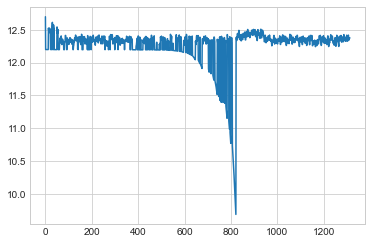

In [42]:
plt.plot(data['Y1'])

C:\Users\Yalikesi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Yalikesi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Yalikesi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


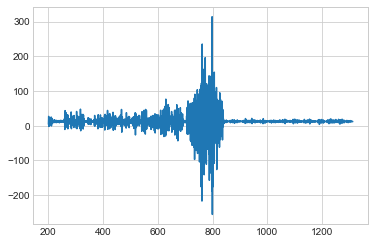

In [63]:
model = ARIMAX(data['Y1'], exog=data[['X11', 'X12', 'X13', 'X14']], order=(0, 0, 1))
plt.plot(model.predict()[200:])

In [30]:
def AcceptableRisk(y_slice, danger_levels):
    deltas = np.diff(y_slice, axis=0).max(axis=0)
    y_to_danger = np.array([
        y_slice[-1][i] - danger_levels[i][1]
        for i in range(len(danger_levels))
    ])
    return max((y_to_danger / deltas).min(), 0)

<ipython-input-30-39fe19e8547c>:7: RuntimeWarning: divide by zero encountered in true_divide
  return max((y_to_danger / deltas).min(), 0)


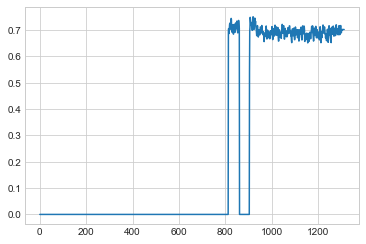

In [37]:
res = []
for s in range(len(data)):
    res.append(AcceptableRisk(data[['Y1', 'Y2', 'Y3']].values[:10+s], danger_levels))

plt.plot(res)

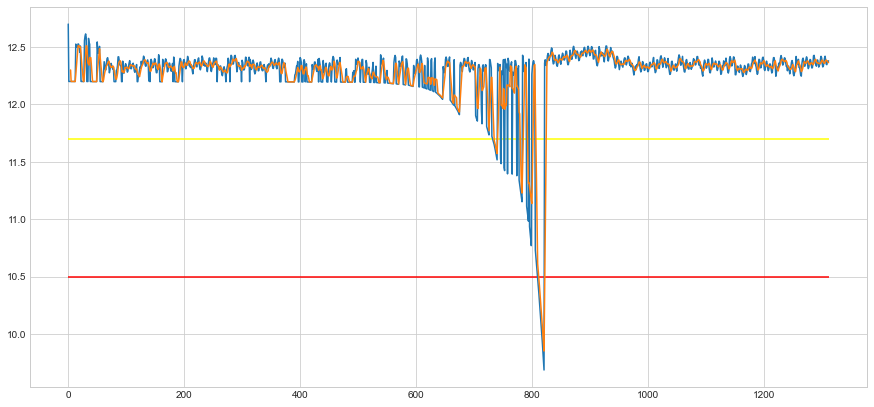

In [123]:
plt.figure(figsize=(15, 7))
plt.plot(data['Y1'])
plt.plot(data['Y1'].rolling(5).mean())
plt.hlines(y=11.7, xmin=0, xmax=len(data), color='yellow')
plt.hlines(y=10.5, xmin=0, xmax=len(data), color='red')
plt.show()

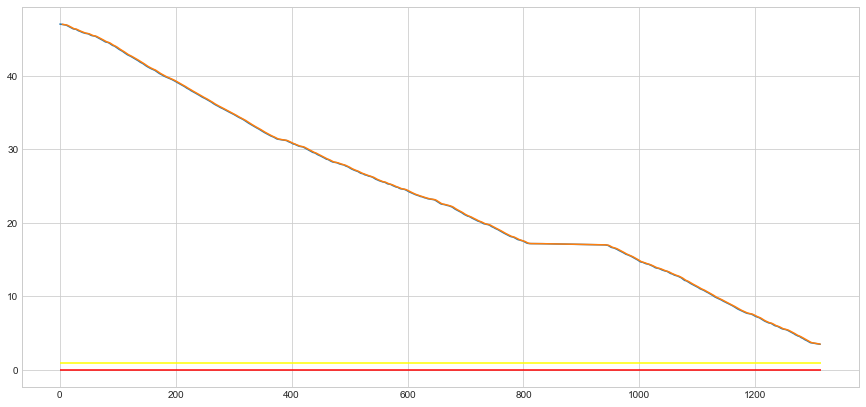

In [124]:
plt.figure(figsize=(15, 7))
plt.plot(data['Y2'])
plt.plot(data['Y2'].rolling(5).mean())
plt.hlines(y=1, xmin=0, xmax=len(data), color='yellow')
plt.hlines(y=0, xmin=0, xmax=len(data), color='red')
plt.show()

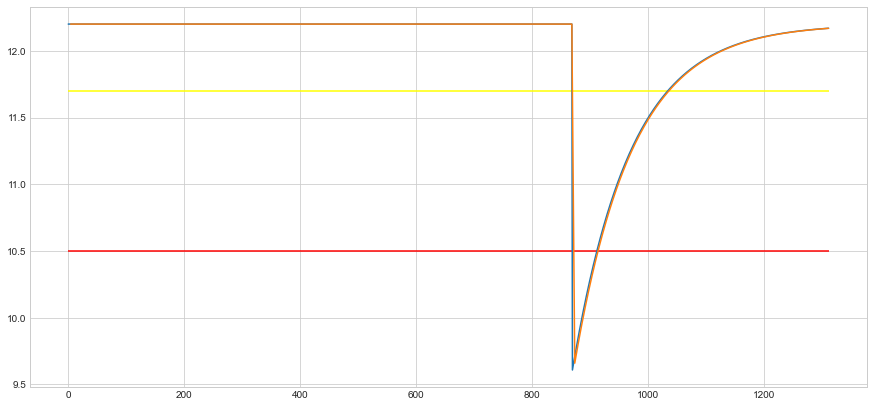

In [125]:
plt.figure(figsize=(15, 7))
plt.plot(data['Y3'])
plt.plot(data['Y3'].rolling(5).mean())
plt.hlines(y=11.7, xmin=0, xmax=len(data), color='yellow')
plt.hlines(y=10.5, xmin=0, xmax=len(data), color='red')
plt.show()

In [158]:
def FaultProb(y, y_emergency, y_fatal, window_size):
    y_ma = pd.DataFrame(y).rolling(window_size).mean().values
    res = (y_emergency - y_ma) / (y_emergency - y_fatal)
    res[res > 1] = 1
    res[res < 0] = 0
    return res

# FaultProb(data['Y1'].values, y_emergency=11.7, y_fatal=10.5, window_size=5).head(100)

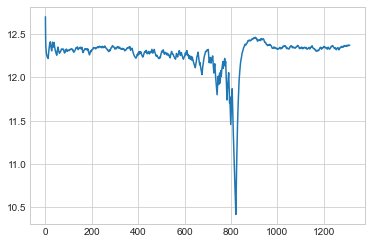

In [152]:
plt.plot(ewma(data['Y1'].values, alpha=0.1))

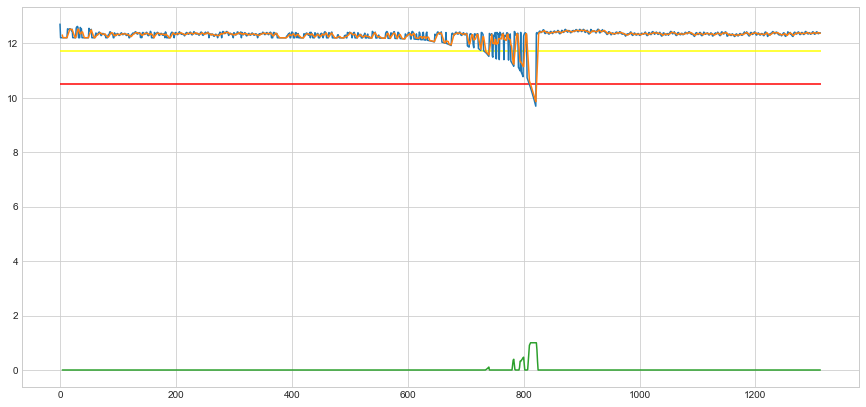

In [159]:
plt.figure(figsize=(15, 7))
plt.plot(data['Y1'])
plt.plot(data['Y1'].rolling(5).mean())
plt.hlines(y=11.7, xmin=0, xmax=len(data), color='yellow')
plt.hlines(y=10.5, xmin=0, xmax=len(data), color='red')
# plt.hlines(y=0, xmin=0, xmax=len(data), color='black')
# plt.hlines(y=1, xmin=0, xmax=len(data), color='black')

plt.plot(FaultProb(data['Y1'].values, y_emergency=11.7, y_fatal=10.5, window_size=5))
plt.show()

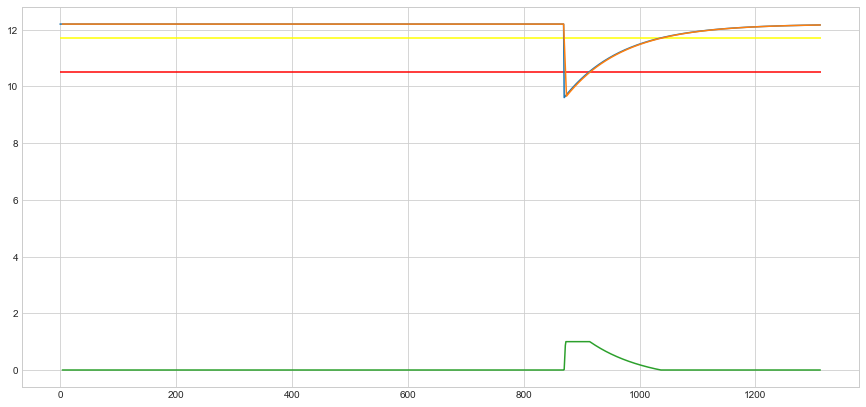

In [169]:
plt.figure(figsize=(15, 7))
plt.plot(data['Y3'])
plt.plot(data['Y3'].rolling(5).mean())
plt.hlines(y=11.7, xmin=0, xmax=len(data), color='yellow')
plt.hlines(y=10.5, xmin=0, xmax=len(data), color='red')
# plt.hlines(y=0, xmin=0, xmax=len(data), color='black')
# plt.hlines(y=1, xmin=0, xmax=len(data), color='black')

plt.plot(FaultProb(data['Y3'].values, y_emergency=11.7, y_fatal=10.5, window_size=5))
plt.show()

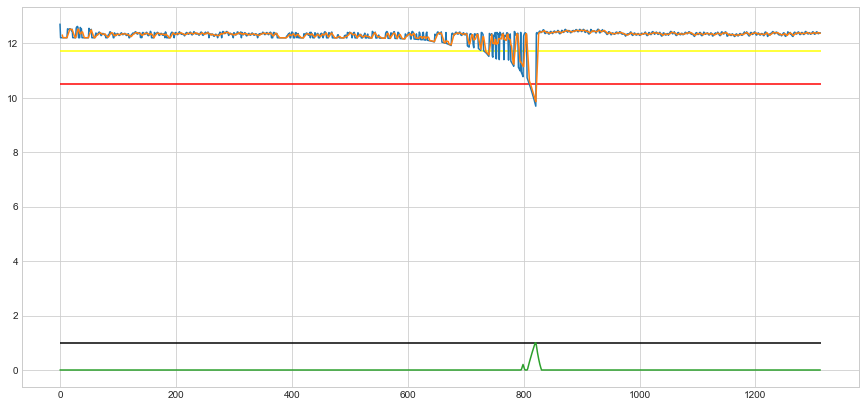

In [155]:
plt.figure(figsize=(15, 7))
plt.plot(data['Y1'])
plt.plot(data['Y1'].rolling(5).mean())
plt.hlines(y=11.7, xmin=0, xmax=len(data), color='yellow')
plt.hlines(y=10.5, xmin=0, xmax=len(data), color='red')
# plt.hlines(y=0, xmin=0, xmax=len(data), color='black')
plt.hlines(y=1, xmin=0, xmax=len(data), color='black')

plt.plot(FaultProb(data['Y1'].values, y_emergency=11.7, y_fatal=10.5, window_size=5))
plt.show()

In [168]:
x = np.random.randn(3,2)
y = np.random.randn(3,)

np.expand_dims(y, axis=1)

array([[-0.63447404],
       [ 0.21898001],
       [-0.12035283]])

In [89]:
data['X14'] - data['X11'].shift(1)

0              NaN
1       545.496430
2       553.607850
3       518.420090
4       472.303390
           ...    
1308    768.615111
1309    772.094555
1310    733.939242
1311    742.843922
1312    732.686955
Length: 1313, dtype: float64

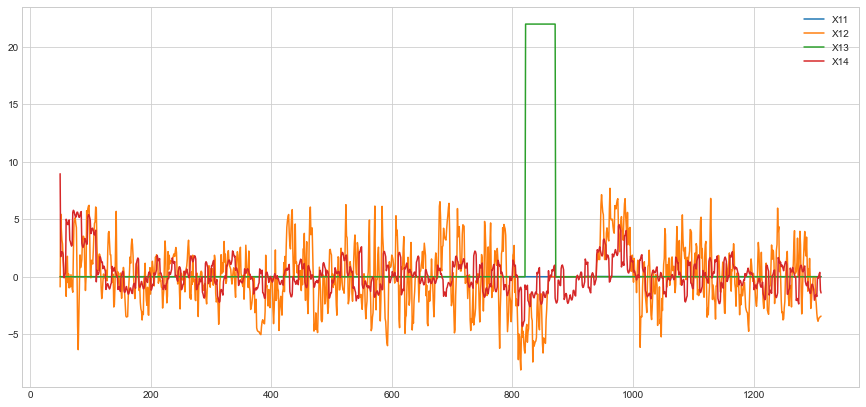

In [91]:
plt.figure(figsize=(15, 7))
for col in ['X11', 'X12', 'X13', 'X14']:
    diff = data[col] - data[col].shift(1)
    plt.plot(diff.rolling(50).mean(), label=col)
plt.legend()
plt.show()

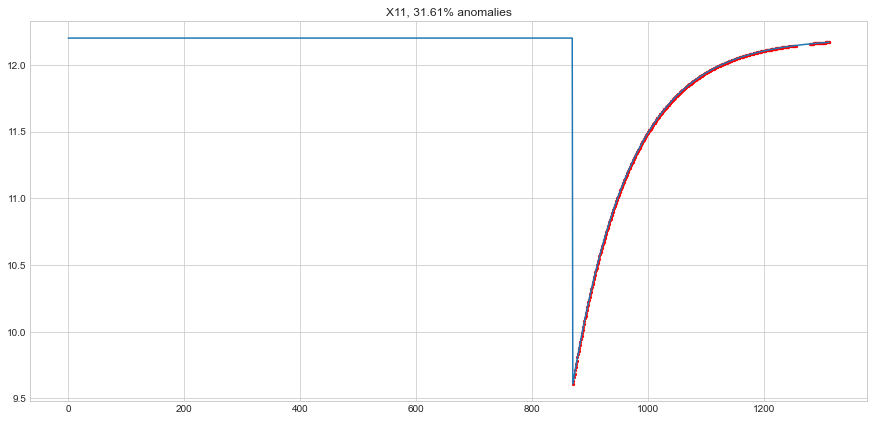

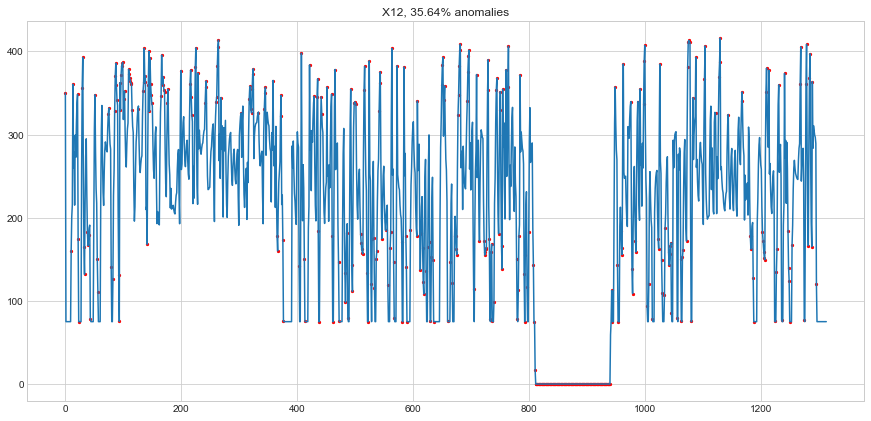

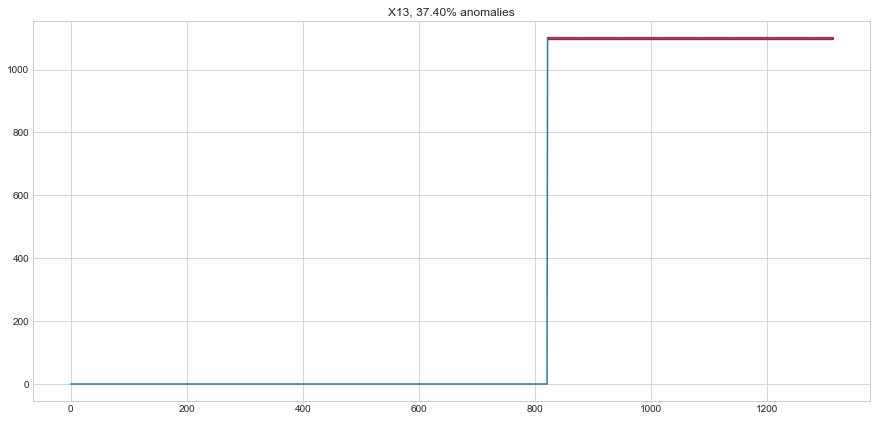

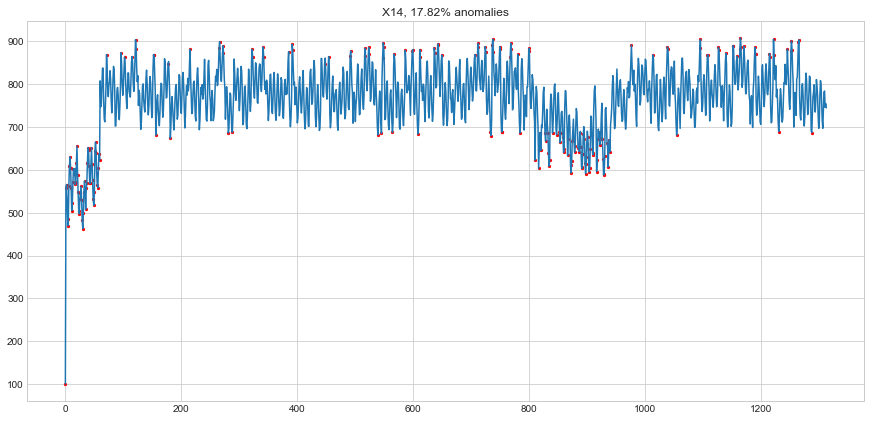

In [95]:
all_pred = []

for col in ['X11', 'X12', 'X13', 'X14']:
    temp_data = data[col].values.reshape(-1, 1)
    clf = IsolationForest(
        random_state=RANDOM_STATE
    ).fit(temp_data)
    pred = clf.predict(temp_data)
    all_pred.append(pred)
    plt.figure(figsize=(15, 7))
    plt.plot(temp_data)
    plt.scatter(np.arange(len(temp_data))[pred == -1], temp_data[pred == -1], c='red', alpha=1, s=5)
    plt.title(f'{col}, {100*(pred == -1).mean():.2f}% anomalies')
    plt.show()

all_pred = np.array(all_pred)

In [104]:
print(all_pred)

[[ 1  1  1 ... -1 -1 -1]
 [-1  1  1 ...  1  1  1]
 [ 1  1  1 ... -1 -1 -1]
 [-1 -1 -1 ...  1  1  1]]


In [106]:
(all_pred.sum(axis=0) == 2).mean()

0.24295506473724296

In [119]:
(all_pred.sum(axis=0) == -2).mean()

0.11348057882711349

In [117]:
np.unique(all_pred.sum(axis=0))

array([-4, -2,  0,  2,  4])

In [120]:
np.argwhere((all_pred.sum(axis=0) == -2))

array([[ 827],
       [ 828],
       [ 832],
       [ 833],
       [ 834],
       [ 835],
       [ 840],
       [ 847],
       [ 852],
       [ 853],
       [ 854],
       [ 858],
       [ 859],
       [ 860],
       [ 866],
       [ 867],
       [ 870],
       [ 875],
       [ 876],
       [ 880],
       [ 881],
       [ 882],
       [ 883],
       [ 888],
       [ 894],
       [ 900],
       [ 906],
       [ 907],
       [ 911],
       [ 912],
       [ 913],
       [ 914],
       [ 915],
       [ 919],
       [ 924],
       [ 925],
       [ 931],
       [ 932],
       [ 933],
       [ 942],
       [ 943],
       [ 948],
       [ 952],
       [ 953],
       [ 958],
       [ 959],
       [ 960],
       [ 962],
       [ 975],
       [ 976],
       [ 977],
       [ 978],
       [ 983],
       [ 984],
       [ 987],
       [ 991],
       [ 997],
       [ 998],
       [ 999],
       [1003],
       [1006],
       [1012],
       [1013],
       [1022],
       [1023],
       [1025],
       [10